# Check Loglikelihood model selection behaviour

We need to verify if the LL is correlated with the Mixture model summary stats fits. If they are not, something went wrong somewhere, or the parameters are interacting in a weird way that we need to understand...

Performed by *generator_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py*


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

In [3]:
import plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import * 

In [4]:
from IPython.html import widgets # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from IPython.html.widgets import interact
from plotly.widgets import GraphWidget 

:0: FutureWarning:

IPython widgets are experimental and may change in the future.



<IPython.core.display.Javascript object>

In [5]:
%run reloader_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py

Reloader data generated from  generator_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py
Running  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/reloader_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py
Arguments: []

        Reload outputs run with the automatic parameter generator for PBS

        Should handle random sampling of the parameter space.
    
Reloader data generated from  generator_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-4af3c05d-4f1c-4f9b-bff9-f23d7088e4cb.npy
0.00%, -- left - 29.10 12:56
M 389.00, ratio_conj 0.93, sigmax 0.43, sigma_output 1.37
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/L

In [6]:
#### SETUP
#
plots_bestfits = True
plots_scatter3d = False

savefigs = True

# dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', label='global_' + dataset_infos['save_output_filename'])

#
#### /SETUP

In [7]:
# Extract data
result_ll_sum_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['results_flat'])
result_ll90_sum_flat = np.array(data_pbs.dict_arrays['result_ll90_sum']['results_flat'])
result_precision_flat = np.array(data_pbs.dict_arrays['result_precision']['results_flat'])
result_em_fits_flat = np.array(data_pbs.dict_arrays['result_em_fits']['results_flat'])
result_emfit_mse_flat = np.array(data_pbs.dict_arrays['result_emfit_mse']['results_flat'])
result_emfit_mixt_kl_flat = np.array(data_pbs.dict_arrays['result_emfit_mixt_kl']['results_flat'])
result_fi_theo_flat = np.array(data_pbs.dict_arrays['result_fi_theo']['results_flat'])
result_fi_theocov_flat = np.array(data_pbs.dict_arrays['result_fi_theocov']['results_flat'])

result_parameters_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['parameters_flat'])
all_repeats_completed = data_pbs.dict_arrays['result_ll_sum']['repeats_completed']

all_args_arr = np.array(data_pbs.loaded_data['args_list'])

M_space = data_pbs.loaded_data['parameters_uniques']['M']
ratio_conj_space = data_pbs.loaded_data['parameters_uniques']['ratio_conj']
sigmax_space = data_pbs.loaded_data['parameters_uniques']['sigmax']
sigmaoutput_space = data_pbs.loaded_data['parameters_uniques']['sigma_output']

num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']

In [8]:
def str_best_params(best_i, result_dist_to_use):
    return '[{:3d}] '.format(best_ind) + ' '.join(["%s %.4f" % (parameter_names_sorted[param_i], result_parameters_flat[best_i, param_i]) 
                     for param_i in xrange(len(parameter_names_sorted))]) + ' >> %f' % result_dist_to_use[best_i]


In [9]:
# Reload experimental data
experiment_id = all_args_arr[0]['experiment_id']
data_groundtruth = load_experimental_data.load_data(experiment_id=experiment_id)
T_space = data_groundtruth['data_to_fit']['n_items']

reloaded mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Bays2009/em_bays_allitems.pickle
reloaded collapsed mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Bays2009/collapsed_em_bays.pickle


In [10]:
## Filter everything with repeats_completed == num_repet
filter_data = all_repeats_completed == num_repetitions - 1

result_parameters_flat = result_parameters_flat[filter_data]
all_args_arr = all_args_arr[filter_data]
all_repeats_completed = all_repeats_completed[filter_data]

print "Size post-filter: ", result_parameters_flat.shape[0]


Size post-filter:  543


In [11]:
# Compute lots of averages over the repetitions
result_ll_sum_avg = utils.nanmean(result_ll_sum_flat, axis=-1)
result_ll90_sum_avg = utils.nanmean(result_ll90_sum_flat, axis=-1)
result_em_fits_avg = utils.nanmean(result_em_fits_flat, axis=-1)
result_emfit_mse_avg = utils.nanmean(result_emfit_mse_flat, axis=-1)
result_emfit_mixt_kl_avg = utils.nanmean(result_emfit_mixt_kl_flat, axis=-1)

# Compute best results
result_dist_emfit_mse = np.nansum(np.nansum(result_emfit_mse_avg, axis=-1), axis=-1)
result_dist_emfit_kl = np.nansum(result_emfit_mixt_kl_avg, axis=-1)
result_dist_nll = np.nansum(-result_ll_sum_avg, axis=-1)
result_dist_nll90 = np.nansum(-result_ll90_sum_avg, axis=-1)

# Get the best fitting parameters
best_params_em = np.argsort(result_dist_emfit_mse)
best_params_kl = np.argsort(result_dist_emfit_kl)
best_params_ll = np.argsort(result_dist_nll)
best_params_ll90 = np.argsort(result_dist_nll90)

## -> Pandas now

In [12]:
df_all_fits = pd.DataFrame.from_items([('M', result_parameters_flat[:, 0]),
                             ('ratio_conj', result_parameters_flat[:, 1]),
                             ('sigmax', result_parameters_flat[:, 2]),
                             ('sigma_output', result_parameters_flat[:, 3]),
                             ('dist_emfit_mse', result_dist_emfit_mse),
                             ('dist_emfit_kl', result_dist_emfit_kl),
                             ('dist_nll', result_dist_nll),
                             ('dist_nll90', result_dist_nll90),
                            ])
df_all_fits = df_all_fits.assign(dist_emfit_mse_log = lambda x: np.log(x['dist_emfit_mse']),
                                   dist_nll_log = lambda x: np.log(x['dist_nll'])
                                  )

In [13]:
# Filter rows where LL > cutoff value
LL_min_cutoff = 3500
df_best_fits = df_all_fits[df_all_fits.dist_nll < LL_min_cutoff]

In [14]:
## Correlations
df_best_fits.corr()

,M,ratio_conj,sigmax,sigma_output,dist_emfit_mse,dist_emfit_kl,dist_nll,dist_nll90,dist_emfit_mse_log,dist_nll_log
M,1.000000,0.125324,0.002741,0.073600,-0.042105,0.032315,-0.040676,-0.079728,0.070525,-0.044101
ratio_conj,0.125324,1.000000,0.111938,0.036522,0.005653,-0.197924,-0.303672,-0.266558,-0.045993,-0.309631
sigmax,0.002741,0.111938,1.000000,-0.199000,-0.049077,0.172534,0.440161,0.398406,0.238294,0.440842
sigma_output,0.073600,0.036522,-0.199000,1.000000,0.081754,0.313475,0.465074,0.647392,0.371573,0.451198
dist_emfit_mse,-0.042105,0.005653,-0.049077,0.081754,1.000000,0.272727,0.052653,0.063140,0.412371,0.051558
dist_emfit_kl,0.032315,-0.197924,0.172534,0.313475,0.272727,1.000000,0.499464,0.468894,0.645254,0.470447
dist_nll,-0.040676,-0.303672,0.440161,0.465074,0.052653,0.499464,1.000000,0.923417,0.430101,0.997325
dist_nll90,-0.079728,-0.266558,0.398406,0.647392,0.063140,0.468894,0.923417,1.000000,0.459149,0.919640
dist_emfit_mse_log,0.070525,-0.045993,0.238294,0.371573,0.412371,0.645254,0.430101,0.459149,1.000000,0.407556
dist_nll_log,-0.044101,-0.309631,0.440842,0.451198,0.051558,0.470447,0.997325,0.919640,0.407556,1.000000


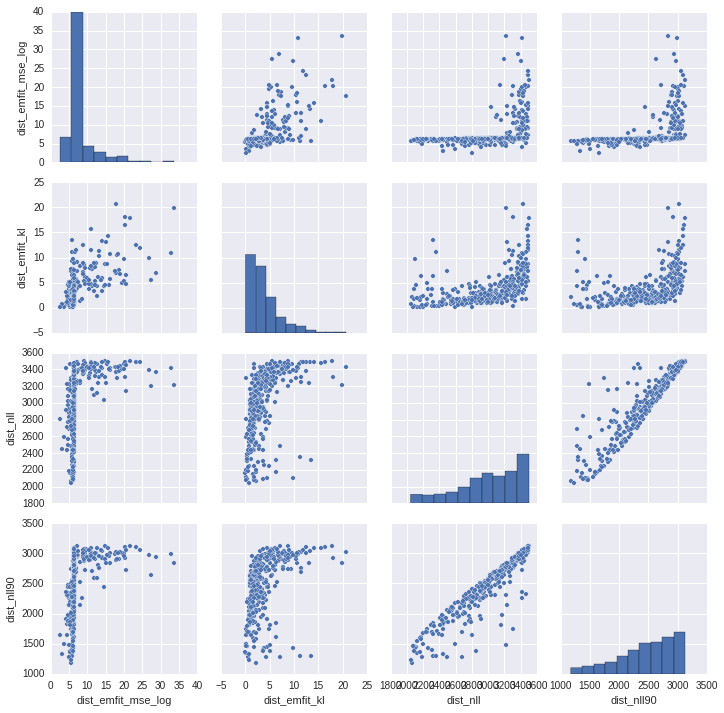

In [15]:
# Cross-correlation plots
sns.pairplot(df_best_fits,
             x_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nll90'],
             y_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nll90']
            )

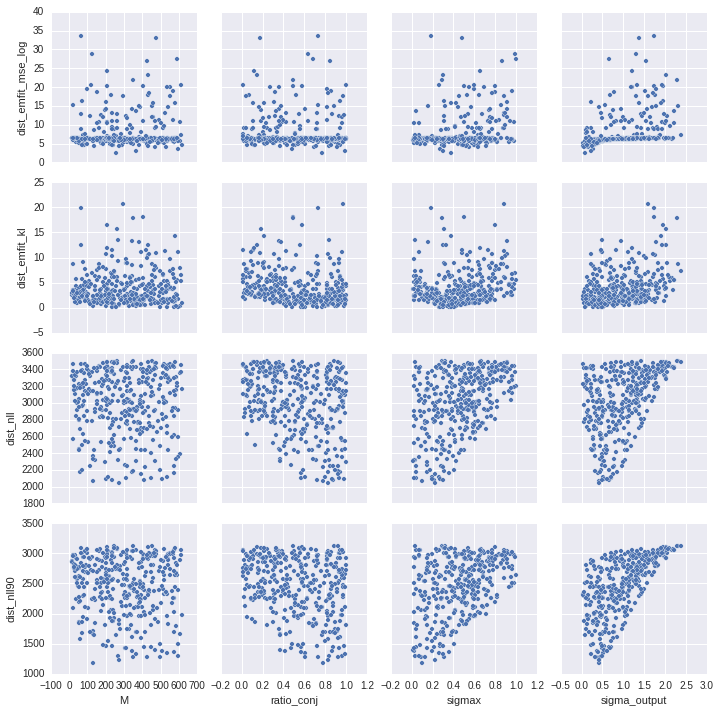

In [16]:
# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax', 'sigma_output'],
             y_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nll90']
            )

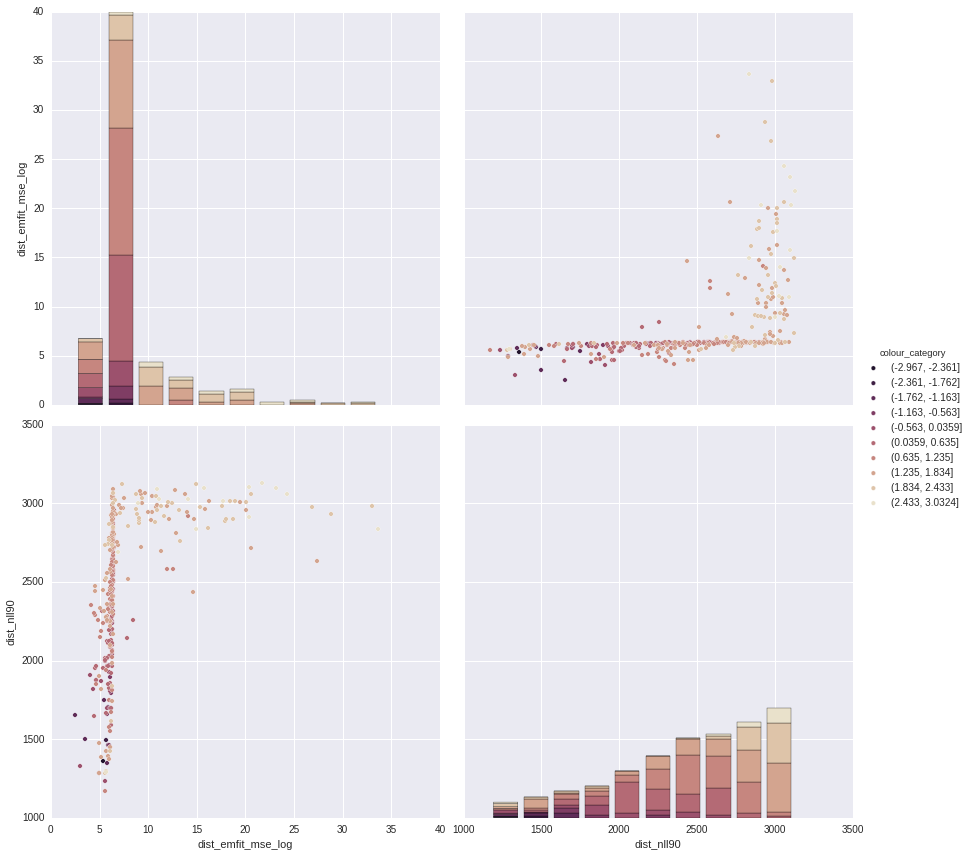

In [17]:
# Color code for Colour KL fit this time 
mycubehelix = sns.cubehelix_palette(dark=0.15, n_colors=10, start=0, rot=0.5, gamma=1.2, hue=0.9, light=0.9, reverse=True)
sns.pairplot(df_best_fits.assign(colour_category=pd.cut(np.log(df_best_fits['dist_emfit_kl']), bins=10)),
             hue='colour_category',
             palette=mycubehelix,
             vars=['dist_emfit_mse_log', 'dist_nll90'],
             size = 6
            )

## Plotly Scatter3d

In [18]:
result_to_color = np.array(df_best_fits.dist_nll90)

col_min = np.min(result_to_color)
col_max = np.max(result_to_color)

text = ['> %s' % (x) for x in result_to_color]

trace1 = Scatter3d(
        x= df_best_fits.M,
        y= df_best_fits.ratio_conj,
        z= df_best_fits.sigmax,
        text= text,
        mode= 'markers',
        marker= Marker(
            color = result_to_color,
            size = 7,
            colorscale='Bluered',
            cmin=col_min,
            cmax=col_max,
            cauto=False
        )
    )
data = Data([trace1])
layout = Layout(
    title='Landscape for NLL90',
    scene=Scene(
        xaxis=XAxis(
            title=df_best_fits.columns.values[0],
        ),
        yaxis=YAxis(
            title=df_best_fits.columns.values[1],
        ),
        zaxis=ZAxis(
            title=df_best_fits.columns.values[2],
        )
    )
)
fig = Figure(data=data, layout=layout)
scatter3d_url = py.plot(fig)

In [19]:
dropdown_space = parameter_names_sorted
dropdown_default = 'sigma_output'
metric_color_space = ['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90']
metric_color_default = 'dist_nll90'

g = GraphWidget(scatter3d_url)

class shifter:
    def __init__(self):
        self.slider_index = 0
        self.marker_size = 8
        self.filter_results = slice(None, None)
        self.metric_color = metric_color_default
        self.dropdown_value = dropdown_default
        
        self.change_color_source(metric_color_default)
        self.change_dropdown_value(dropdown_default)
    
    def change_dropdown_value(self, new_value):
        self.dropdown_value = new_value
        
        # Update the axes
        self.axes_parameters = dropdown_space[:]
        self.axes_parameters.remove(self.dropdown_value)
        
        # Update the grid of the dropdown parameter
        self.dropparam_gridified, self.dropparam_gridspace, self.dropparam_midspace = utils.gridify(df_best_fits[self.dropdown_value], bins=10)
        
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
    
    def change_color_source(self, new_value):
        self.metric_color = new_value
        self.result_to_color = np.array(df_best_fits[self.metric_color])
        self.result_to_color[self.result_to_color > 2*np.median(self.result_to_color)] = np.median(self.result_to_color)
        self.col_min = np.min(self.result_to_color)
        self.col_max = np.max(self.result_to_color)
    
    def on_color_source_change(self, name, old_value, new_value):
        self.change_color_source(new_value)
        self.replot()
    
    def on_dropdown_change(self, name, old_value, new_value):
        self.change_dropdown_value(new_value)
        p_slider.description='%s [all]' % self.dropdown_value
        self.replot()
    
    def on_slider_change(self, name, old_value, new_value):
        self.slider_index = new_value
        
        if self.slider_index > -1:
            self.filter_results = self.dropparam_gridified[self.slider_index]
            self.marker_size = 6
            p_slider.description='%s [%f]' % (self.dropdown_value, self.dropparam_gridspace[self.slider_index])
        else:
            self.filter_results = slice(None, None)
            self.marker_size = 6
            p_slider.description='%s [all]' % self.dropdown_value
        
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        self.replot()
        
    def replot(self):
        new_trace = Scatter3d(
            x= df_best_fits[self.axes_parameters[0]][self.filter_results],
            y= df_best_fits[self.axes_parameters[1]][self.filter_results],
            z= df_best_fits[self.axes_parameters[2]][self.filter_results],
            text= self.text,
            mode= 'markers',
            marker= Marker(
                color = self.result_to_color[self.filter_results],
                size = self.marker_size,
                colorscale='Bluered',
                cmin=self.col_min,
                cmax=self.col_max,
                cauto=False
            )
        )
        g.restyle({'x': [[]], 'y': [[]], 'z': [[]], 'marker':None, })
        g.relayout({'title' : "Landscape for %s" % self.metric_color,
                    'scene.xaxis.title': self.axes_parameters[0],
                    'scene.yaxis.title': self.axes_parameters[1],
                    'scene.zaxis.title': self.axes_parameters[2],
                    })
        g.add_traces(new_trace)

p_state = shifter()
p_metric_drop = widgets.Dropdown(description='Metric for color', options=metric_color_space, value=metric_color_default)
p_variable_drop = widgets.Dropdown(description='Variable to slide', options=dropdown_space, value=dropdown_default)
p_slider = widgets.IntSlider(min=-1, max=p_state.dropparam_midspace.size-1, value=-1)
p_slider.description='%s [all]' % p_state.dropdown_value

p_slider.on_trait_change(p_state.on_slider_change, 'value')
p_variable_drop.on_trait_change(p_state.on_dropdown_change, 'value')
p_metric_drop.on_trait_change(p_state.on_color_source_change, 'value')

p_state.replot()

In [20]:
display(p_metric_drop)
display(p_variable_drop)
display(p_slider)
display(g)

## Look at best parameters


In [21]:
max_best_params = 10
print 'EM MSE'
print '\n'.join([str_best_params(best_ind, result_dist_emfit_mse) for best_ind in best_params_em[:max_best_params]])

print
print 'EM KL'
print '\n'.join([str_best_params(best_ind, result_dist_emfit_kl) for best_ind in best_params_kl[:max_best_params]])

print
print 'LL'
print '\n'.join([str_best_params(best_ind, result_dist_nll) for best_ind in best_params_ll[:max_best_params]])

print
print 'LL90'
print '\n'.join([str_best_params(best_ind, result_dist_nll90) for best_ind in best_params_ll90[:max_best_params]])

EM MSE
[464] M 254.0000 ratio_conj 0.7717 sigmax 0.3764 sigma_output 0.0754 >> 12.178680
[387] M 365.0000 ratio_conj 0.9890 sigmax 0.3029 sigma_output 0.2151 >> 20.586848
[340] M 595.0000 ratio_conj 0.4857 sigmax 0.2674 sigma_output 0.2632 >> 33.812636
[324] M 470.0000 ratio_conj 0.6894 sigmax 0.5468 sigma_output 0.1425 >> 56.983587
[459] M 528.0000 ratio_conj 0.9167 sigmax 0.6391 sigma_output 0.0665 >> 62.650339
[332] M 274.0000 ratio_conj 0.7153 sigmax 0.5212 sigma_output 0.1206 >> 76.601981
[441] M 433.0000 ratio_conj 0.8337 sigmax 0.7153 sigma_output 0.0428 >> 85.104631
[511] M 135.0000 ratio_conj 0.3630 sigmax 0.3125 sigma_output 0.2427 >> 85.504491
[  5] M 384.0000 ratio_conj 0.5104 sigmax 0.6029 sigma_output 0.1889 >> 96.077465
[176] M 290.0000 ratio_conj 0.0552 sigmax 0.4968 sigma_output 0.2523 >> 96.113512

EM KL
[263] M 574.0000 ratio_conj 0.5645 sigmax 0.3596 sigma_output 0.3931 >> 0.051791
[285] M 495.0000 ratio_conj 0.5838 sigmax 0.4015 sigma_output 0.4558 >> 0.095731
[464

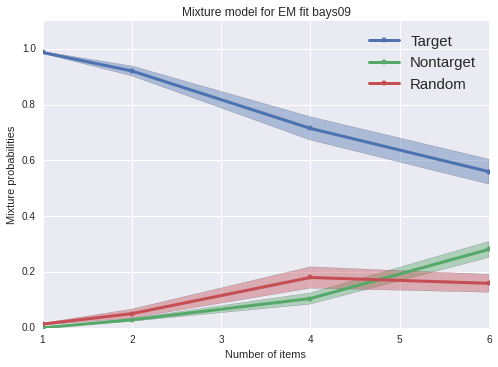

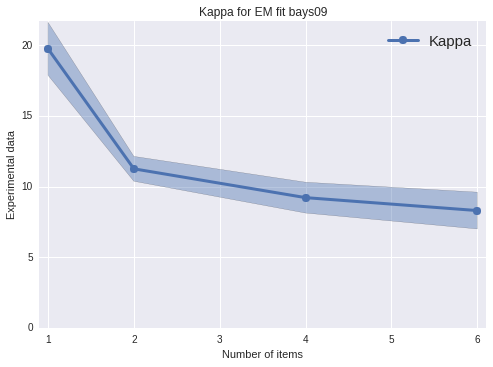

In [22]:
# Ground truth
plots_experimental_data.plots_bays2009(data_groundtruth)

In [23]:
# Plot best
def plot_modelfits(T_space, curr_result_emfits_t, labelplot='', dataio=None):
    curr_result_avg = np.mean(curr_result_emfits_t, axis=-1)
    curr_result_std = np.std(curr_result_emfits_t, axis=-1)
    
    f, ax = plt.subplots()    
    ax = plots_experimental_data.plot_kappa_mean_error(T_space, curr_result_avg[..., 0], curr_result_std[..., 0], title=labelplot, ax=ax, label='Kappa', xlabel='Number of items')

    if dataio is not None:
        dataio.save_current_figure('bestfit_%s_kappa_{label}_{unique_id}.pdf' % labelplot)

    f, ax = plt.subplots()
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 1], curr_result_std[..., 1], title=labelplot, label='Target', ax=ax)
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 2], curr_result_std[..., 2], title=labelplot, label='Nontarget', ax=ax)
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 3], curr_result_std[..., 3], title=labelplot, label='Random', ax=ax)
    
    if dataio is not None:
        dataio.save_current_figure('bestfit_%s_mixttarget_{label}_{unique_id}.pdf' % labelplot)

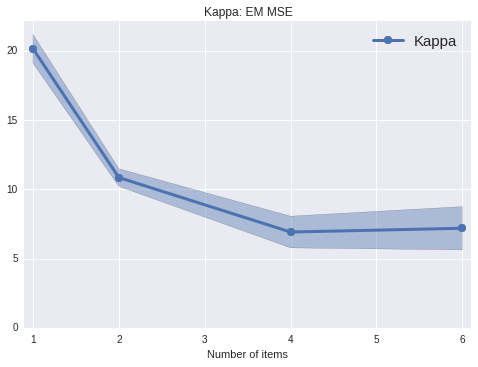

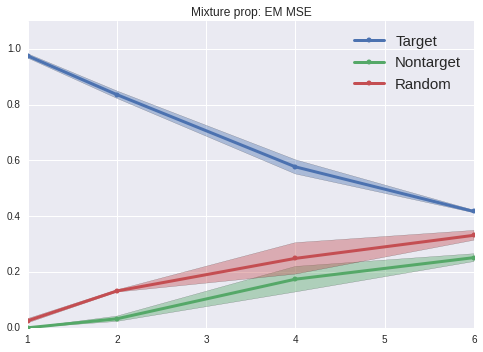

In [24]:
# Best fit for EM MSE
@interact(best_index=(0, 10, 1))
def plot_model_fit(best_index=0):
    plot_modelfits(T_space, result_em_fits_flat[best_params_em[best_index]], 'EM MSE')

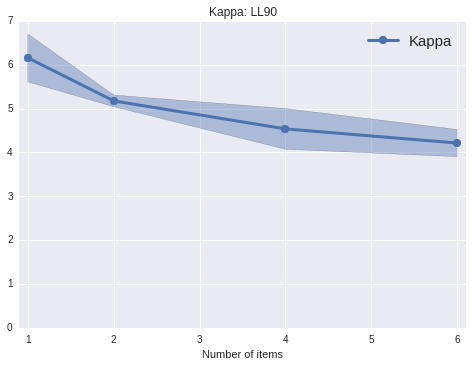

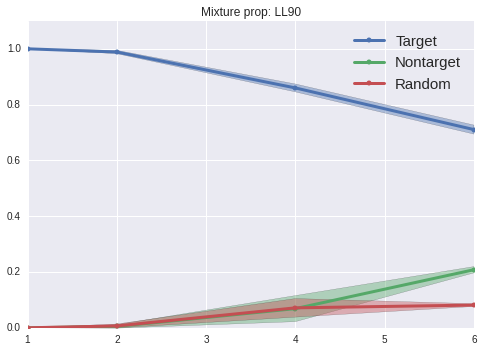

In [25]:
# Best fit for LL90
@interact(best_index=(0, 10, 1))
def plot_model_fit(best_index=0):
    plot_modelfits(T_space, result_em_fits_flat[best_params_ll90[best_index]], 'LL90')

# Observations

I think that the LL requires too high Sigma_output in order to get likely samples.
This corresponds to what I saw before, most points are too unlikely with a very flat sampling posterior, and sigma_output alleviates that.

It's flagrant with the correlation between sigma_output and emfit_MSE, where having sigma_output too high will destroy the fit of Kappas.

Hence we really need to move to another likelihood function, not with sigma_output, but with a baseline lapse rate. This should provide a small amount of support everywhere, without interacting with kappa at all.
Let's hope that will work.

It's unclear if starting CMA/ES runs will be useful or not.